In [ ]:
import math
from collections import Counter

def entropy(data):
    labels = [row[-1] for row in data]
    counts = Counter(labels)
    total = len(data)
    return -sum((count/total) * math.log2(count/total) for count in counts.values())

def info_gain(data, attr_index):
    total_entropy = entropy(data)
    attr_values = set(row[attr_index] for row in data)
    weighted_entropy = 0
    for value in attr_values:
        subset = [row for row in data if row[attr_index] == value]
        weighted_entropy += (len(subset)/len(data)) * entropy(subset)
    return total_entropy - weighted_entropy

def id3(data, attributes):
    labels = [row[-1] for row in data]
    if labels.count(labels[0]) == len(labels):
        return labels[0]
    if not attributes:
        return Counter(labels).most_common(1)[0][0]

    gains = [info_gain(data, i) for i in attributes]
    best_attr = attributes[gains.index(max(gains))]
    tree = {best_attr: {}}
    attr_values = set(row[best_attr] for row in data)

    for value in attr_values:
        subset = [row for row in data if row[best_attr] == value]
        new_attrs = [i for i in attributes if i != best_attr]
        subtree = id3(subset, new_attrs)
        tree[best_attr][value] = subtree
    return tree

In [ ]:
def split_info(data, attr_index):
    attr_values = set(row[attr_index] for row in data)
    total = len(data)
    return -sum((len([row for row in data if row[attr_index] == val])/total) *
                math.log2(len([row for row in data if row[attr_index] == val])/total)
                for val in attr_values)

def gain_ratio(data, attr_index):
    ig = info_gain(data, attr_index)
    si = split_info(data, attr_index)
    return ig / si if si != 0 else 0

def c45(data, attributes):
    labels = [row[-1] for row in data]
    if labels.count(labels[0]) == len(labels):
        return labels[0]
    if not attributes:
        return Counter(labels).most_common(1)[0][0]

    ratios = [gain_ratio(data, i) for i in attributes]
    best_attr = attributes[ratios.index(max(ratios))]
    tree = {best_attr: {}}
    attr_values = set(row[best_attr] for row in data)

    for value in attr_values:
        subset = [row for row in data if row[best_attr] == value]
        new_attrs = [i for i in attributes if i != best_attr]
        subtree = c45(subset, new_attrs)
        tree[best_attr][value] = subtree
    return tree

In [ ]:
def gini(data):
    labels = [row[-1] for row in data]
    counts = Counter(labels)
    total = len(data)
    return 1 - sum((count/total)**2 for count in counts.values())

def gini_split(data, attr_index):
    attr_values = set(row[attr_index] for row in data)
    min_gini = float('inf')
    best_split = None

    for value in attr_values:
        left = [row for row in data if row[attr_index] == value]
        right = [row for row in data if row[attr_index] != value]
        gini_val = (len(left)/len(data)) * gini(left) + (len(right)/len(data)) * gini(right)
        if gini_val < min_gini:
            min_gini = gini_val
            best_split = value
    return min_gini, best_split

def cart(data, attributes):
    labels = [row[-1] for row in data]
    if labels.count(labels[0]) == len(labels):
        return labels[0]
    if not attributes:
        return Counter(labels).most_common(1)[0][0]

    best_attr, best_value = None, None
    min_gini = float('inf')
    for i in attributes:
        gini_val, split_val = gini_split(data, i)
        if gini_val < min_gini:
            min_gini = gini_val
            best_attr, best_value = i, split_val

    tree = {f"{best_attr} == {best_value}": {}}
    left = [row for row in data if row[best_attr] == best_value]
    right = [row for row in data if row[best_attr] != best_value]
    new_attrs = [i for i in attributes if i != best_attr]
    tree[f"{best_attr} == {best_value}"]['yes'] = cart(left, new_attrs)
    tree[f"{best_attr} == {best_value}"]['no'] = cart(right, new_attrs)
    return tree

In [ ]:
data = [
    ['Sunny', 'Hot', 'High', 'Weak', 'No'],
    ['Sunny', 'Hot', 'High', 'Strong', 'No'],
    ['Overcast', 'Hot', 'High', 'Weak', 'Yes'],
    ['Rain', 'Mild', 'High', 'Weak', 'Yes'],
    ['Rain', 'Cool', 'Normal', 'Weak', 'Yes'],
    ['Rain', 'Cool', 'Normal', 'Strong', 'No'],
    ['Overcast', 'Cool', 'Normal', 'Strong', 'Yes'],
    ['Sunny', 'Mild', 'High', 'Weak', 'No'],
    ['Sunny', 'Cool', 'Normal', 'Weak', 'Yes'],
    ['Rain', 'Mild', 'Normal', 'Weak', 'Yes'],
    ['Sunny', 'Mild', 'Normal', 'Strong', 'Yes'],
    ['Overcast', 'Mild', 'High', 'Strong', 'Yes'],
    ['Overcast', 'Hot', 'Normal', 'Weak', 'Yes'],
    ['Rain', 'Mild', 'High', 'Strong', 'No']
]

attributes = [0, 1, 2, 3]
def print_tree(tree, indent=""):
    if isinstance(tree, dict):
        for key, value in tree.items():
            print(indent + str(key))
            print_tree(value, indent + "  ")
    else:
        print(indent + "→ " + str(tree))

print("ID3 Decision Tree:")
id3_tree = id3(data, attributes)
print_tree(id3_tree)

print("\nC4.5 Decision Tree:")
c45_tree = c45(data, attributes)
print_tree(c45_tree)

print("\nCART Decision Tree:")
cart_tree = cart(data, attributes)
print_tree(cart_tree)

ID3 Decision Tree:
0
  Sunny
    2
      Normal
        → Yes
      High
        → No
  Rain
    3
      Weak
        → Yes
      Strong
        → No
  Overcast
    → Yes

C4.5 Decision Tree:
0
  Sunny
    2
      Normal
        → Yes
      High
        → No
  Rain
    3
      Weak
        → Yes
      Strong
        → No
  Overcast
    → Yes

CART Decision Tree:
0 == Overcast
  yes
    → Yes
  no
    2 == Normal
      yes
        3 == Weak
          yes
            → Yes
          no
            1 == Mild
              yes
                → Yes
              no
                → No
      no
        1 == Mild
          yes
            3 == Weak
              yes
                → Yes
              no
                → No
          no
            → No


In [ ]:
def predict(tree, sample):
    while isinstance(tree, dict):
        key = list(tree.keys())[0]


        if isinstance(key, str) and "==" in key:
            attr, val = key.split(" == ")
            attr = int(attr)
            branch = 'yes' if sample[attr] == val else 'no'
        else:
            attr = key
            val = sample[attr]
            branch = val

        if branch not in tree[key]:
            return None
        tree = tree[key][branch]
    return tree

def evaluate(tree, data, name="Model"):
    correct = 0
    print(f"\n {name} Predictions:")
    print(f"{'Sample':<40} {'Predicted':<10} {'Actual':<10}")
    print("-" * 60)
    for sample in data:
        pred = predict(tree, sample)
        actual = sample[-1]
        print(f"{str(sample[:-1]):<40} {str(pred):<10} {actual:<10}")
        if pred == actual:
            correct += 1
    accuracy = correct / len(data)
    print(f"\n Accuracy of {name}: {accuracy:.2%}")


id3_tree = id3(data, attributes)
c45_tree = c45(data, attributes)
cart_tree = cart(data, attributes)


evaluate(id3_tree, data, "ID3")
evaluate(c45_tree, data, "C4.5")
evaluate(cart_tree, data, "CART")


 ID3 Predictions:
Sample                                   Predicted  Actual    
------------------------------------------------------------
['Sunny', 'Hot', 'High', 'Weak']         No         No        
['Sunny', 'Hot', 'High', 'Strong']       No         No        
['Overcast', 'Hot', 'High', 'Weak']      Yes        Yes       
['Rain', 'Mild', 'High', 'Weak']         Yes        Yes       
['Rain', 'Cool', 'Normal', 'Weak']       Yes        Yes       
['Rain', 'Cool', 'Normal', 'Strong']     No         No        
['Overcast', 'Cool', 'Normal', 'Strong'] Yes        Yes       
['Sunny', 'Mild', 'High', 'Weak']        No         No        
['Sunny', 'Cool', 'Normal', 'Weak']      Yes        Yes       
['Rain', 'Mild', 'Normal', 'Weak']       Yes        Yes       
['Sunny', 'Mild', 'Normal', 'Strong']    Yes        Yes       
['Overcast', 'Mild', 'High', 'Strong']   Yes        Yes       
['Overcast', 'Hot', 'Normal', 'Weak']    Yes        Yes       
['Rain', 'Mild', 'High', 'Strong']    

In [11]:
from graphviz import Digraph

def visualize_tree(tree, graph=None, parent=None, edge_label=""):
    if graph is None:
        graph = Digraph()
        graph.attr('node', shape='box')

    if isinstance(tree, dict):
        for node_label, subtree in tree.items():
            node_id = str(id(subtree))  # Ensure node ID is a string
            graph.node(node_id, str(node_label))  # Ensure label is a string
            if parent:
                graph.edge(parent, node_id, label=str(edge_label))
            visualize_tree(subtree, graph, node_id)
    else:
        leaf_id = str(id(tree))
        graph.node(leaf_id, f"→ {str(tree)}", shape='ellipse', style='filled', color='lightgrey')
        if parent:
            graph.edge(parent, leaf_id, label=str(edge_label))

    return graph

In [12]:
id3_tree = id3(data, attributes)
graph = visualize_tree(id3_tree)
graph.render("id3_tree", format="png", cleanup=True)  # Saves as id3_tree.png


'id3_tree.png'

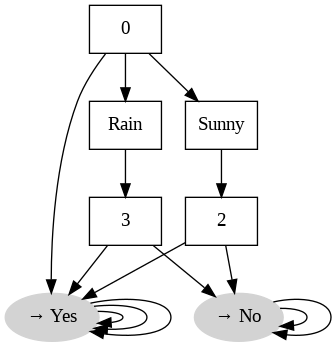

In [13]:
from graphviz import Digraph
from IPython.display import Image, display

def visualize_tree(tree, graph=None, parent=None, edge_label=""):
    if graph is None:
        graph = Digraph()
        graph.attr('node', shape='box')

    if isinstance(tree, dict):
        for node_label, subtree in tree.items():
            node_id = str(id(subtree))
            graph.node(node_id, str(node_label))
            if parent:
                graph.edge(parent, node_id, label=str(edge_label))
            visualize_tree(subtree, graph, node_id)
    else:
        leaf_id = str(id(tree))
        graph.node(leaf_id, f"→ {str(tree)}", shape='ellipse', style='filled', color='lightgrey')
        if parent:
            graph.edge(parent, leaf_id, label=str(edge_label))

    return graph

# Example usage for ID3 tree
id3_tree = id3(data, attributes)
graph = visualize_tree(id3_tree)
graph.render("id3_tree", format="png", cleanup=True)

# Display in Colab output cell
display(Image(filename="id3_tree.png"))